In [1]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [3]:
from pathlib import Path
import pyarrow as pa, pyarrow.parquet as pq
import pandas as pd
import numpy as np

from VR_Trajectory_analysis import *        # load_csv, process_dataframe, parse_angle_from_config
import data_ingestion as dig                # your helper module

# --- config ---
cfg = dig.Config(parquet_root=Path("/Users/apaula/ownCloud/stage_parquet_gray_angle_sweep_50"))
SNAP_ROOT = cfg.parquet_root / "_snapshots"
SNAP_ROOT.mkdir(exist_ok=True, parents=True)

# --- 1) Ingest ---
dig.ingest_run_directory(
    Path("/Users/apaula/ownCloud/MatrexVR1/20250725_Gray_AngleSweep/20251013_GrayAngleSweep_V2_Data/RunData"),
    trim_seconds=1.0,
    parquet_root=cfg.parquet_root,
    load_csv=load_csv,
    process_dataframe=process_dataframe,
)

# --- 2) Load slim dataset ---
df_all = dig.load_dataset_subset_as_pandas(cfg.parquet_root, wanted_cols=dig.CORE_COLS)
df_all = dig.add_trial_id_and_displacement(df_all)

# --- 3) Filter ---
mask = (df_all.get("stepName", pd.Series(index=df_all.index, dtype="object")) != "skybox") & \
       (df_all["TotalDisplacement"].gt(12))
df_filtered = df_all.loc[mask].copy()
_, df_normal, _, *_ = dig.classify_by_path_length(df_filtered, min_length=0, max_length=100)

# --- 4) Trial summary ---
if "stepName" in df_normal.columns:
    step_str = df_normal["stepName"].astype("string[python]")
    df_normal["Angle"] = step_str.apply(lambda x: parse_angle_from_config(x, default_angle=np.nan))
    df_normal[["shade1", "shade2", "conflict_angle"]] = (
        step_str.str.extract(r'_(\d{2})_(\d{2})_(\d{2,3})deg$').astype(float)
    )
else:
    df_normal["Angle"] = np.nan
    df_normal[["shade1", "shade2", "conflict_angle"]] = np.nan

trial_summary = (
    df_normal.sort_values(["UniqueTrialID", "elapsed_time"], kind="mergesort")
             .groupby("UniqueTrialID", observed=True)
             .agg(
                 FlyID=("FlyID", "first"),
                 angle=("Angle", "first"),
                 travel_dir=("TravelDirectionDeg", "first"),
                 shade1=("shade1", "first"),
                 shade2=("shade2", "first"),
                 conflict_angle=("conflict_angle", "first"),
                 run=("run", "first"),
                 vr=("vr", "first"),
             )
             .dropna(subset=["angle", "travel_dir"])
             .reset_index(drop=True)
)
trial_summary["travel_dir_signed"] = ((trial_summary["travel_dir"] + 180) % 360) - 180

# --- 5) Save snapshots ---
pq.write_table(pa.Table.from_pandas(df_normal.reset_index(drop=True), preserve_index=False),
               SNAP_ROOT / "df_normal.parquet", compression="zstd")
pq.write_table(pa.Table.from_pandas(trial_summary.reset_index(drop=True), preserve_index=False),
               SNAP_ROOT / "trial_summary.parquet", compression="zstd")

print("💾 Saved df_normal & trial_summary snapshots.")


[ingest] 20251013_135403
  (no CSVs) 20251013_135403
[ingest] 20251013_144426
  wrote /Users/apaula/ownCloud/stage_parquet_gray_angle_sweep_50/run=20251013_144426/vr=vr1/flyid=k1bmyy/20251013_144426_Choice_desync_VR1_.parquet
  wrote /Users/apaula/ownCloud/stage_parquet_gray_angle_sweep_50/run=20251013_144426/vr=vr2/flyid=k1bmwm/20251013_144426_Choice_desync_VR2_.parquet
  wrote /Users/apaula/ownCloud/stage_parquet_gray_angle_sweep_50/run=20251013_144426/vr=vr3/flyid=k1bmmy/20251013_144426_Choice_desync_VR3_.parquet
  wrote /Users/apaula/ownCloud/stage_parquet_gray_angle_sweep_50/run=20251013_144426/vr=vr4/flyid=k1rbgk/20251013_144426_Choice_desync_VR4_.parquet
[ingest] 20251014_100602
  wrote /Users/apaula/ownCloud/stage_parquet_gray_angle_sweep_50/run=20251014_100602/vr=vr1/flyid=k1mbmg/20251014_100602_Choice_desync_VR1_.parquet
  wrote /Users/apaula/ownCloud/stage_parquet_gray_angle_sweep_50/run=20251014_100602/vr=vr2/flyid=k1bmkg/20251014_100602_Choice_desync_VR2_.parquet
  wrote /

In [4]:
from pathlib import Path
import pandas as pd

PARQUET_ROOT = Path('/Users/apaula/ownCloud/stage_parquet_gray_angle_sweep_50')
SNAP_ROOT = PARQUET_ROOT / "_snapshots"

# Load the trial summary snapshot
trial_summary = pd.read_parquet(SNAP_ROOT / "trial_summary.parquet", engine="pyarrow")

# Or load df_normal if you need it
df_normal = pd.read_parquet(SNAP_ROOT / "df_normal.parquet", engine="pyarrow")

print(trial_summary.head())


    FlyID  angle  travel_dir  shade1  shade2  conflict_angle              run  \
0  k1kmyy   70.0   43.128479    50.0     0.0            70.0  20251016_114845   
1  k1mwmr   90.0   30.355840     0.0    50.0            90.0  20251015_093437   
2  k1bmmb   50.0    2.521995    50.0     0.0            50.0  20251014_144448   
3  k1wmkb  100.0  316.279570     0.0    50.0           100.0  20251015_140526   
4  k1mwmr  140.0  300.579295     0.0    50.0           140.0  20251015_093437   

    vr  travel_dir_signed  
0  vr3          43.128479  
1  vr4          30.355840  
2  vr3           2.521995  
3  vr3         -43.720430  
4  vr4         -59.420705  


In [9]:
print(trial_summary.head())
print(df_normal.head())

    FlyID  angle  travel_dir  shade1  shade2  conflict_angle              run  \
0  k1kmyy   70.0   43.128479    50.0     0.0            70.0  20251016_114845   
1  k1mwmr   90.0   30.355840     0.0    50.0            90.0  20251015_093437   
2  k1bmmb   50.0    2.521995    50.0     0.0            50.0  20251014_144448   
3  k1wmkb  100.0  316.279570     0.0    50.0           100.0  20251015_140526   
4  k1mwmr  140.0  300.579295     0.0    50.0           140.0  20251015_093437   

    vr  travel_dir_signed  
0  vr3          43.128479  
1  vr4          30.355840  
2  vr3           2.521995  
3  vr3         -43.720430  
4  vr4         -59.420705  
                               SourceFile  CurrentStep  CurrentTrial  \
0  20251016_114845_Choice_desync_VR3_.csv            1             0   
1  20251016_114845_Choice_desync_VR3_.csv            1             0   
2  20251016_114845_Choice_desync_VR3_.csv            1             0   
3  20251016_114845_Choice_desync_VR3_.csv            1   

In [5]:

# --- Select and prepare Group A (mirror travel direction) ---
group_a = trial_summary[
    (trial_summary['shade1'] == 0) &
    (trial_summary['shade2'] == 50)
].copy()
group_a['travel_dir_signed'] = -group_a['travel_dir_signed']
group_a['group'] = 'mirror (shade1=50, shade2=0)'

# --- Group B (no mirroring) ---
group_b = trial_summary[
    (trial_summary['shade1'] == 50) &
    (trial_summary['shade2'] == 0)
].copy()
group_b['group'] = 'original (shade1=0, shade2=50)'

# --- Combine mirrored + original ---
group_ab = pd.concat([group_a, group_b], ignore_index=True)

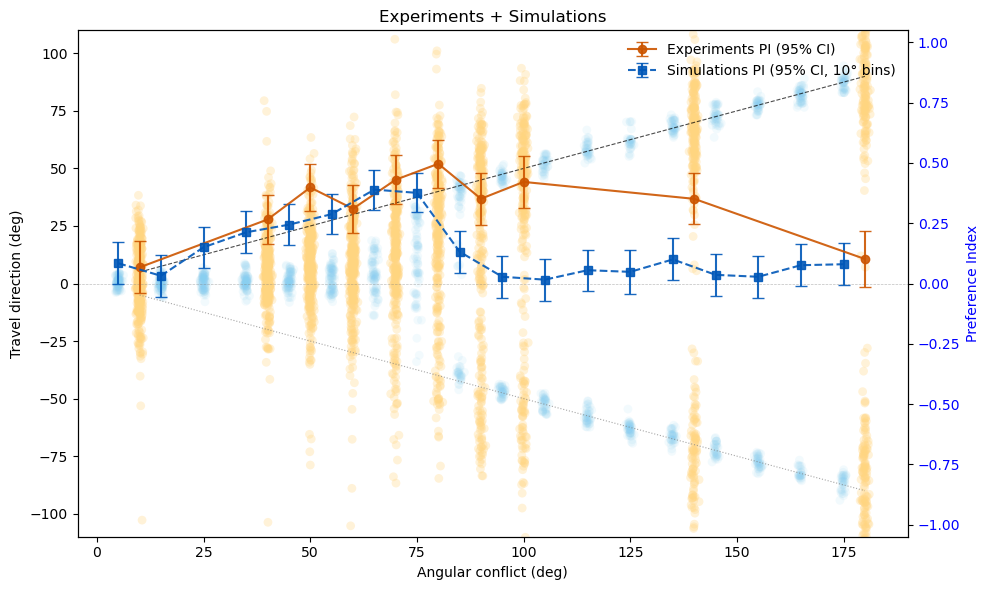

In [6]:
# --- COMBINED PLOT: Experiments (exact angles) + Simulations (10° bins) with distinct colors ---
import os, json, h5py
import numpy as np
import matplotlib.pyplot as plt

# ==== CONFIG ====
sim_data_folder = "/Users/apaula/src/SimulationResults/20250811_183013_sweep_angles_symmetric_kappa_10_10_strength_0.9_1.0_prerun"
sim_h5_path = os.path.join(sim_data_folder, "experiment.h5")
angle_bin_deg = 10  # for simulations
snap_tol_deg = 0.75  # tolerance for snapping sim angles to nearest bin center for scatter display

# Colors: (bright points, dark line)
sim_point_color = "#89CFF0"  # bright blue
sim_line_color  = "#0057B8"  # dark blue
exp_point_color = "#FFD580"  # bright orange
exp_line_color  = "#CC5500"  # dark orange

# ---------- Helpers ----------
def compute_pi(vals):
    vals = np.asarray(vals, dtype=float)
    n_pos = np.sum(vals > 0)
    n_neg = np.sum(vals < 0)
    total = n_pos + n_neg
    if total > 0:
        p = n_pos / total
        pi = 2*p - 1
        se_p = np.sqrt(p * (1 - p) / total)
        ci95 = 1.96 * (2 * se_p)
    else:
        pi, ci95 = np.nan, np.nan
    return pi, ci95

def _read_ds(g, name):
    if name not in g:
        return None
    ds = g[name]
    enc = ds.attrs.get("encoding", None)
    if enc == b"json-utf8" or enc == "json-utf8":
        payload = bytes(ds[:].tolist())
        return np.array(json.loads(payload.decode("utf-8")))
    return ds[:]

# ---------- Load simulations (into degrees) ----------
angles_to_finaldirs_deg = {}
with h5py.File(sim_h5_path, "r") as f:
    runs = f["runs"]
    for run_name in runs:
        g = runs[run_name]
        angle_attr = float(g.attrs["angle"])
        avg_dir = _read_ds(g, "average_direction")
        if avg_dir is None or len(avg_dir) == 0:
            continue
        if abs(angle_attr) <= np.pi and np.nanmax(np.abs(avg_dir)) <= np.pi + 1e-6:
            angle_deg = float(np.degrees(angle_attr))
            final_direction_deg = float(np.degrees(np.array(avg_dir, dtype=float)[-1]))
        else:
            angle_deg = float(angle_attr)
            final_direction_deg = float(np.array(avg_dir, dtype=float)[-1])
        angles_to_finaldirs_deg.setdefault(angle_deg, []).append(final_direction_deg)

# ---------- PI for experiments (exact angles) ----------
exp_angles_deg = sorted(group_ab['angle'].unique())
exp_centers, exp_pi, exp_ci95 = [], [], []
for a in exp_angles_deg:
    vals = group_ab.loc[group_ab['angle'] == a, 'travel_dir_signed'].values
    pi, ci = compute_pi(vals)
    exp_centers.append(a); exp_pi.append(pi); exp_ci95.append(ci)
exp_centers = np.array(exp_centers)
exp_pi = np.array(exp_pi)
exp_ci95 = np.array(exp_ci95)

# ---------- PI for simulations (10° bins) ----------
angle_min = max(0, np.floor(min(angles_to_finaldirs_deg.keys())))
angle_max = min(180, np.ceil(max(angles_to_finaldirs_deg.keys())))
edges = np.arange(angle_min, angle_max + angle_bin_deg, angle_bin_deg)
sim_bin_centers = 0.5 * (edges[:-1] + edges[1:])
sim_pi = []
sim_ci95 = []
for lo, hi in zip(edges[:-1], edges[1:]):
    bin_vals = []
    for angle_val, dirs in angles_to_finaldirs_deg.items():
        if lo <= angle_val < hi:
            bin_vals.extend(dirs)
    pi, ci = compute_pi(bin_vals)
    sim_pi.append(pi)
    sim_ci95.append(ci)
sim_pi = np.array(sim_pi)
sim_ci95 = np.array(sim_ci95)

# ---------- Combined plot ----------
rng = np.random.default_rng(42)
def jitter(x, scale=0.4):
    return x + rng.normal(0, scale, size=len(x))

fig, ax1 = plt.subplots(figsize=(10, 6))

# Scatter experiments (bright blue)
ax1.scatter(jitter(group_ab['angle'].values), group_ab['travel_dir_signed'].values,
            s=40, alpha=0.3, color=exp_point_color, edgecolors='none')

# Scatter simulations (bright orange)
sim_angles_all, sim_dirs_all = [], []
bin_centers_arr = np.array(sim_bin_centers)
for a, vals in angles_to_finaldirs_deg.items():
    nearest_bin = bin_centers_arr[np.argmin(np.abs(bin_centers_arr - a))]
    if abs(nearest_bin - a) <= snap_tol_deg:
        sim_angles_all.extend([nearest_bin]*len(vals))
        sim_dirs_all.extend(vals)
if sim_angles_all:
    ax1.scatter(jitter(np.array(sim_angles_all)), np.array(sim_dirs_all),
                s=40, alpha=0.1, color=sim_point_color, edgecolors='none')

# Reference lines
x_line = np.linspace(min(exp_angles_deg), max(exp_angles_deg), 160)
ax1.plot(x_line,  0.5 * x_line, ls='--', c='black', lw=0.8, alpha=0.7)
ax1.plot(x_line, -0.5 * x_line, ls=':',  c='grey',  lw=0.8, alpha=0.7)
ax1.axhline(0, color='grey', ls='--', lw=0.5, alpha=0.5)

# PI overlays (dark versions)
ax2 = ax1.twinx()
ax2.errorbar(
    exp_centers, exp_pi, yerr=exp_ci95,
    fmt='o-', capsize=4, alpha=0.9, color=exp_line_color,
    label='Experiments PI (95% CI)'
)
ax2.errorbar(
    sim_bin_centers, sim_pi, yerr=sim_ci95,
    fmt='s--', capsize=4, alpha=0.9, color=sim_line_color,
    label=f'Simulations PI (95% CI, {angle_bin_deg}° bins)'
)

# Labels, limits, title
ax1.set_xlabel("Angular conflict (deg)")
ax1.set_ylabel("Travel direction (deg)", color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(-110, 110)
ax2.set_ylabel('Preference Index', color='blue')
ax2.set_ylim(-1.05, 1.05)
ax2.tick_params(axis='y', labelcolor='blue')
plt.title('Experiments + Simulations')

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', frameon=False)

fig.tight_layout()
plt.show()


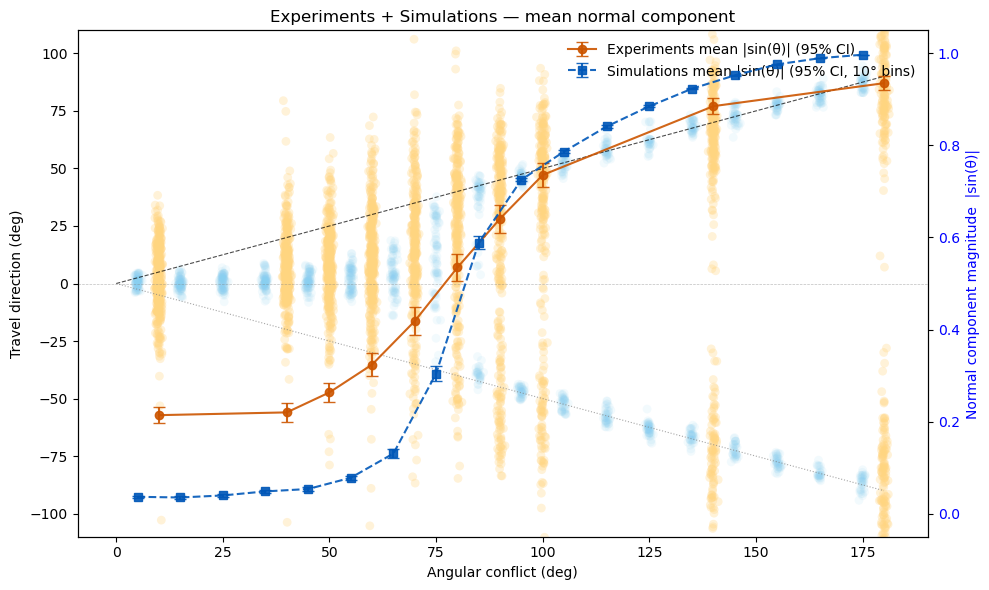

In [7]:
# --- COMBINED PLOT: Experiments (exact angles) + Simulations (10° bins)
# --- Order parameter: mean |sin(direction)| (unitless, 0..1) ---
import os, json, h5py
import numpy as np
import matplotlib.pyplot as plt

# ==== CONFIG ====
sim_data_folder = "/Users/apaula/src/SimulationResults/20250811_183013_sweep_angles_symmetric_kappa_10_10_strength_0.9_1.0_prerun"
sim_h5_path = os.path.join(sim_data_folder, "experiment.h5")
angle_bin_deg = 10    # for simulations
snap_tol_deg = 0.75   # tolerance for snapping sim angles to nearest bin center for scatter display

# Colors: (bright points, dark line)
sim_point_color = "#89CFF0"  # bright blue
sim_line_color  = "#0057B8"  # dark blue
exp_point_color = "#FFD580"  # bright orange
exp_line_color  = "#CC5500"  # dark orange

# ---------- Helpers ----------
def mean_ci95(vals):
    """Return (mean, 95% CI half-width) for finite vals using normal approx.
       If n<2 => CI is nan."""
    x = np.asarray(vals, dtype=float)
    x = x[np.isfinite(x)]
    n = x.size
    if n == 0:
        return np.nan, np.nan
    m = np.mean(x)
    if n < 2:
        return m, np.nan
    s = np.std(x, ddof=1)
    ci = 1.96 * s / np.sqrt(n)
    # order parameter is in [0, 1]; clip to stay in-range visually
    return m, np.clip(ci, 0.0, 1.0)

def normal_component_magnitude_deg(direction_deg_array):
    """Compute |sin(theta)| where theta is in degrees."""
    theta_rad = np.radians(direction_deg_array.astype(float))
    return np.abs(np.sin(theta_rad))

def _read_ds(g, name):
    if name not in g:
        return None
    ds = g[name]
    enc = ds.attrs.get("encoding", None)
    if enc == b"json-utf8" or enc == "json-utf8":
        payload = bytes(ds[:].tolist())
        return np.array(json.loads(payload.decode("utf-8")))
    return ds[:]

# ---------- Load simulations (into degrees) ----------
angles_to_finaldirs_deg = {}
with h5py.File(sim_h5_path, "r") as f:
    runs = f["runs"]
    for run_name in runs:
        g = runs[run_name]
        angle_attr = float(g.attrs["angle"])
        avg_dir = _read_ds(g, "average_direction")
        if avg_dir is None or len(avg_dir) == 0:
            continue
        # detect radians vs degrees
        if abs(angle_attr) <= np.pi and np.nanmax(np.abs(avg_dir)) <= np.pi + 1e-6:
            angle_deg = float(np.degrees(angle_attr))
            final_direction_deg = float(np.degrees(np.array(avg_dir, dtype=float)[-1]))
        else:
            angle_deg = float(angle_attr)
            final_direction_deg = float(np.array(avg_dir, dtype=float)[-1])
        angles_to_finaldirs_deg.setdefault(angle_deg, []).append(final_direction_deg)

# ---------- Order parameter for experiments (exact angles) ----------
# expects: group_ab with columns ['angle', 'travel_dir_signed'] in degrees
exp_angles_deg = sorted(group_ab['angle'].unique())
exp_centers, exp_mean_nc, exp_ci95 = [], [], []
for a in exp_angles_deg:
    dirs_deg = group_ab.loc[group_ab['angle'] == a, 'travel_dir_signed'].values
    nc = normal_component_magnitude_deg(dirs_deg)
    m, ci = mean_ci95(nc)
    exp_centers.append(a); exp_mean_nc.append(m); exp_ci95.append(ci)
exp_centers = np.array(exp_centers)
exp_mean_nc = np.array(exp_mean_nc)
exp_ci95 = np.array(exp_ci95)

# ---------- Order parameter for simulations (10° bins) ----------
if len(angles_to_finaldirs_deg) == 0:
    raise ValueError("No simulation runs loaded; check sim_h5_path.")

angle_min = max(0, np.floor(min(angles_to_finaldirs_deg.keys())))
angle_max = min(180, np.ceil(max(angles_to_finaldirs_deg.keys())))
edges = np.arange(angle_min, angle_max + angle_bin_deg, angle_bin_deg)
sim_bin_centers = 0.5 * (edges[:-1] + edges[1:])
sim_mean_nc, sim_ci95 = [], []
for lo, hi in zip(edges[:-1], edges[1:]):
    bin_dirs = []
    for angle_val, dirs in angles_to_finaldirs_deg.items():
        if lo <= angle_val < hi:
            bin_dirs.extend(dirs)
    bin_dirs = np.array(bin_dirs, dtype=float)
    nc = normal_component_magnitude_deg(bin_dirs)
    m, ci = mean_ci95(nc)
    sim_mean_nc.append(m)
    sim_ci95.append(ci)
sim_mean_nc = np.array(sim_mean_nc)
sim_ci95 = np.array(sim_ci95)

# ---------- Combined plot ----------
rng = np.random.default_rng(42)
def jitter(x, scale=0.4):
    return x + rng.normal(0, scale, size=len(x))

fig, ax1 = plt.subplots(figsize=(10, 6))

# Scatter experiments (raw directions, bright orange)
ax1.scatter(jitter(group_ab['angle'].values), group_ab['travel_dir_signed'].values,
            s=40, alpha=0.3, color=exp_point_color, edgecolors='none')

# Scatter simulations (raw directions, bright blue), snapped to nearest bin center for display
sim_angles_all, sim_dirs_all = [], []
bin_centers_arr = np.array(sim_bin_centers)
for a, vals in angles_to_finaldirs_deg.items():
    nearest_bin = bin_centers_arr[np.argmin(np.abs(bin_centers_arr - a))]
    if abs(nearest_bin - a) <= snap_tol_deg:
        sim_angles_all.extend([nearest_bin] * len(vals))
        sim_dirs_all.extend(vals)
if sim_angles_all:
    ax1.scatter(jitter(np.array(sim_angles_all)), np.array(sim_dirs_all),
                s=40, alpha=0.1, color=sim_point_color, edgecolors='none')

# Reference lines on direction axis
x_line_min = min(min(exp_angles_deg), edges[0])
x_line_max = max(max(exp_angles_deg), edges[-1])
x_line = np.linspace(x_line_min, x_line_max, 200)
ax1.plot(x_line,  0.5 * x_line, ls='--', c='black', lw=0.8, alpha=0.7)
ax1.plot(x_line, -0.5 * x_line, ls=':',  c='grey',  lw=0.8, alpha=0.7)
ax1.axhline(0, color='grey', ls='--', lw=0.5, alpha=0.5)

# Order parameter overlays (right y-axis)
ax2 = ax1.twinx()
ax2.errorbar(
    exp_centers, exp_mean_nc, yerr=exp_ci95,
    fmt='o-', capsize=4, alpha=0.9, color=exp_line_color,
    label='Experiments mean |sin(θ)| (95% CI)'
)
ax2.errorbar(
    sim_bin_centers, sim_mean_nc, yerr=sim_ci95,
    fmt='s--', capsize=4, alpha=0.9, color=sim_line_color,
    label=f'Simulations mean |sin(θ)| (95% CI, {angle_bin_deg}° bins)'
)

# Labels, limits, title
ax1.set_xlabel("Angular conflict (deg)")
ax1.set_ylabel("Travel direction (deg)", color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(-110, 110)

ax2.set_ylabel('Normal component magnitude  |sin(θ)|', color='blue')
ax2.set_ylim(-0.05, 1.05)
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('Experiments + Simulations — mean normal component')

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', frameon=False)

fig.tight_layout()
plt.show()


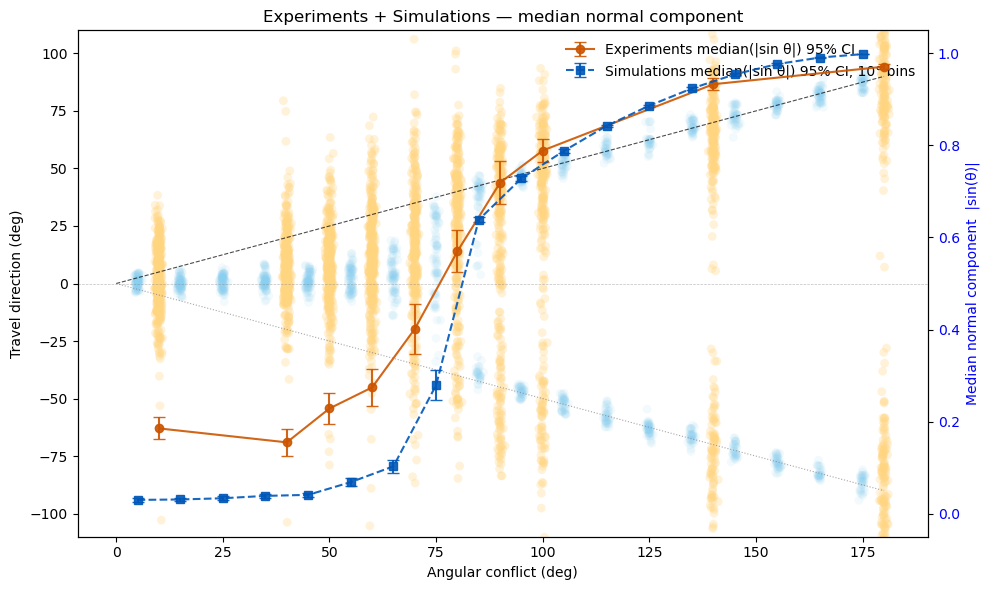

In [8]:
# --- COMBINED PLOT: Experiments (exact angles) + Simulations (10° bins)
# --- Order parameter: median/mode of |sin(direction)| with 95% bootstrap CI ---
import os, json, h5py
import numpy as np
import matplotlib.pyplot as plt

# ==== CONFIG ====
sim_data_folder = "/Users/apaula/src/SimulationResults/20250811_183013_sweep_angles_symmetric_kappa_10_10_strength_0.9_1.0_prerun"
sim_h5_path = os.path.join(sim_data_folder, "experiment.h5")
angle_bin_deg = 10    # for simulations
snap_tol_deg = 0.75   # tolerance for snapping sim angles to nearest bin center for scatter display
ORDER_STAT = "median" # choose: "median" or "mode"
N_BOOT = 1000         # bootstrap samples for CI

# Colors: (bright points, dark line)
sim_point_color = "#89CFF0"  # bright blue
sim_line_color  = "#0057B8"  # dark blue
exp_point_color = "#FFD580"  # bright orange
exp_line_color  = "#CC5500"  # dark orange

# ---------- Helpers ----------
def _read_ds(g, name):
    if name not in g:
        return None
    ds = g[name]
    enc = ds.attrs.get("encoding", None)
    if enc == b"json-utf8" or enc == "json-utf8":
        payload = bytes(ds[:].tolist())
        return np.array(json.loads(payload.decode("utf-8")))
    return ds[:]

def normal_component_magnitude_deg(direction_deg_array):
    """Compute |sin(theta)| where theta is in degrees (returns in [0,1])."""
    theta_rad = np.radians(direction_deg_array.astype(float))
    return np.abs(np.sin(theta_rad))

def _mode_hist(x, bins="fd"):
    """Histogram-mode estimator: return bin center of the highest-density bin."""
    if isinstance(bins, str) and bins == "fd":
        # Freedman–Diaconis; fallback to 10 bins if degenerate
        q25, q75 = np.percentile(x, [25, 75])
        iqr = q75 - q25
        h = 2 * iqr * (len(x) ** (-1/3)) if iqr > 0 else 0
        if h > 0:
            bins = max(5, int(np.ceil((x.max() - x.min()) / h)))
        else:
            bins = 10
    counts, edges = np.histogram(x, bins=bins, range=(0.0, 1.0))
    k = np.argmax(counts)
    return 0.5 * (edges[k] + edges[k+1])

def order_stat_with_ci(x, stat="median", n_boot=1000, rng_seed=0):
    """Return (estimate, ci_halfwidth) for stat in {'median','mode'} using bootstrap 95% CI."""
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    n = x.size
    if n == 0:
        return np.nan, np.nan
    if stat == "median":
        est = np.median(x)
        if n < 2:
            return est, np.nan
        rng = np.random.default_rng(rng_seed)
        boots = []
        for _ in range(n_boot):
            sample = rng.choice(x, size=n, replace=True)
            boots.append(np.median(sample))
        lo, hi = np.percentile(boots, [2.5, 97.5])
    elif stat == "mode":
        est = _mode_hist(x)
        if n < 3:
            return est, np.nan
        rng = np.random.default_rng(rng_seed)
        boots = []
        for _ in range(n_boot):
            sample = rng.choice(x, size=n, replace=True)
            boots.append(_mode_hist(sample))
        lo, hi = np.percentile(boots, [2.5, 97.5])
    else:
        raise ValueError("stat must be 'median' or 'mode'")
    ci_half = 0.5 * (hi - lo)
    return float(est), float(ci_half)

# ---------- Load simulations (into degrees) ----------
angles_to_finaldirs_deg = {}
with h5py.File(sim_h5_path, "r") as f:
    runs = f["runs"]
    for run_name in runs:
        g = runs[run_name]
        angle_attr = float(g.attrs["angle"])
        avg_dir = _read_ds(g, "average_direction")
        if avg_dir is None or len(avg_dir) == 0:
            continue
        # detect radians vs degrees
        if abs(angle_attr) <= np.pi and np.nanmax(np.abs(avg_dir)) <= np.pi + 1e-6:
            angle_deg = float(np.degrees(angle_attr))
            final_direction_deg = float(np.degrees(np.array(avg_dir, dtype=float)[-1]))
        else:
            angle_deg = float(angle_attr)
            final_direction_deg = float(np.array(avg_dir, dtype=float)[-1])
        angles_to_finaldirs_deg.setdefault(angle_deg, []).append(final_direction_deg)

if len(angles_to_finaldirs_deg) == 0:
    raise ValueError("No simulation runs loaded; check sim_h5_path.")

# ---------- Order statistic for experiments (exact angles) ----------
# expects: group_ab with columns ['angle', 'travel_dir_signed'] in degrees
exp_angles_deg = sorted(group_ab['angle'].unique())
exp_centers, exp_stat, exp_ci = [], [], []
for a in exp_angles_deg:
    dirs_deg = group_ab.loc[group_ab['angle'] == a, 'travel_dir_signed'].values
    nc = normal_component_magnitude_deg(dirs_deg)
    est, ci = order_stat_with_ci(nc, stat=ORDER_STAT, n_boot=N_BOOT, rng_seed=123)
    exp_centers.append(a); exp_stat.append(est); exp_ci.append(ci)
exp_centers = np.array(exp_centers)
exp_stat = np.array(exp_stat)
exp_ci = np.array(exp_ci)

# ---------- Order statistic for simulations (10° bins) ----------
angle_min = max(0, np.floor(min(angles_to_finaldirs_deg.keys())))
angle_max = min(180, np.ceil(max(angles_to_finaldirs_deg.keys())))
edges = np.arange(angle_min, angle_max + angle_bin_deg, angle_bin_deg)
sim_bin_centers = 0.5 * (edges[:-1] + edges[1:])
sim_stat, sim_ci = [], []
for lo, hi in zip(edges[:-1], edges[1:]):
    bin_dirs = []
    for angle_val, dirs in angles_to_finaldirs_deg.items():
        if lo <= angle_val < hi:
            bin_dirs.extend(dirs)
    if len(bin_dirs) == 0:
        sim_stat.append(np.nan); sim_ci.append(np.nan); continue
    nc = normal_component_magnitude_deg(np.array(bin_dirs, dtype=float))
    est, ci = order_stat_with_ci(nc, stat=ORDER_STAT, n_boot=N_BOOT, rng_seed=456)
    sim_stat.append(est); sim_ci.append(ci)
sim_stat = np.array(sim_stat)
sim_ci = np.array(sim_ci)

# ---------- Combined plot ----------
rng = np.random.default_rng(42)
def jitter(x, scale=0.4):
    return x + rng.normal(0, scale, size=len(x))

fig, ax1 = plt.subplots(figsize=(10, 6))

# Scatter experiments (raw directions)
ax1.scatter(jitter(group_ab['angle'].values), group_ab['travel_dir_signed'].values,
            s=40, alpha=0.3, color=exp_point_color, edgecolors='none', label=None)

# Scatter simulations (raw directions), snapped to nearest bin center for display
sim_angles_all, sim_dirs_all = [], []
bin_centers_arr = np.array(sim_bin_centers)
for a, vals in angles_to_finaldirs_deg.items():
    nearest_bin = bin_centers_arr[np.argmin(np.abs(bin_centers_arr - a))]
    if abs(nearest_bin - a) <= snap_tol_deg:
        sim_angles_all.extend([nearest_bin] * len(vals))
        sim_dirs_all.extend(vals)
if sim_angles_all:
    ax1.scatter(jitter(np.array(sim_angles_all)), np.array(sim_dirs_all),
                s=40, alpha=0.1, color=sim_point_color, edgecolors='none', label=None)

# Reference lines (direction axis)
x_line_min = min(min(exp_angles_deg), edges[0])
x_line_max = max(max(exp_angles_deg), edges[-1])
x_line = np.linspace(x_line_min, x_line_max, 200)
ax1.plot(x_line,  0.5 * x_line, ls='--', c='black', lw=0.8, alpha=0.7)
ax1.plot(x_line, -0.5 * x_line, ls=':',  c='grey',  lw=0.8, alpha=0.7)
ax1.axhline(0, color='grey', ls='--', lw=0.5, alpha=0.5)

# Order-stat overlays (right y-axis)
ax2 = ax1.twinx()
label_name = "median" if ORDER_STAT == "median" else "mode"
ax2.errorbar(
    exp_centers, exp_stat, yerr=exp_ci,
    fmt='o-', capsize=4, alpha=0.9, color=exp_line_color,
    label=f'Experiments {label_name}(|sin θ|) 95% CI'
)
ax2.errorbar(
    sim_bin_centers, sim_stat, yerr=sim_ci,
    fmt='s--', capsize=4, alpha=0.9, color=sim_line_color,
    label=f'Simulations {label_name}(|sin θ|) 95% CI, {angle_bin_deg}° bins'
)

# Labels, limits, title
ax1.set_xlabel("Angular conflict (deg)")
ax1.set_ylabel("Travel direction (deg)", color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(-110, 110)

ax2.set_ylabel(f'{label_name.capitalize()} normal component  |sin(θ)|', color='blue')
ax2.set_ylim(-0.05, 1.05)
ax2.tick_params(axis='y', labelcolor='blue')

plt.title(f'Experiments + Simulations — {label_name} normal component')

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', frameon=False)

fig.tight_layout()
plt.show()
